**Import thư viện**

In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image


**Tải và chuẩn bị dữ liệu**

In [78]:

# Đường dẫn đến thư mục data
data_dir = Path("./data/")

# Lấy danh sách tất cả các file trong thư mục data
files = list(data_dir.glob("*"))

# Lọc ra chỉ các file có định dạng .png
images = [file for file in files if file.suffix == ".png"]

# Sắp xếp danh sách ảnh
images = sorted(list(map(str, images)))

# Tạo nhãn từ tên file (bỏ phần path và phần mở rộng)
labels = [
    img.split(os.path.sep)[-1].split(".")[0] for img in images
]

# Tìm các ký tự độc nhất trong tất cả các nhãn
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Số lượng ảnh: ", len(images))
print("Số lượng nhãn: ", len(labels))
print("Số lượng ký tự độc nhất: ", len(characters))
print("Các ký tự: ", characters)
print("Độ dài tối đa của CAPTCHA: ", max([len(label) for label in labels]))


Số lượng ảnh:  620
Số lượng nhãn:  620
Số lượng ký tự độc nhất:  43
Các ký tự:  ['2', '3', '4', '5', '6', '7', '8', '9', 'C', 'F', 'G', 'J', 'K', 'M', 'N', 'P', 'Q', 'S', 'V', 'W', 'X', 'Y', 'Z', 'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']
Độ dài tối đa của CAPTCHA:  6


**Vệ sinh dữ liệu**

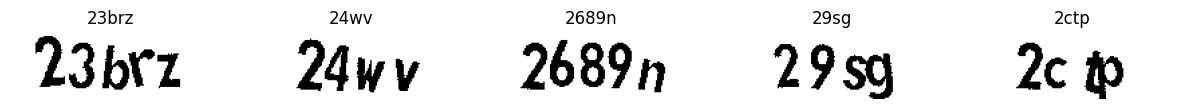

Kích thước ảnh thực tế: (150, 50)


In [79]:
# Kiểm tra và hiển thị dữ liệu
plt.figure(figsize=(15, 5))
for i in range(min(5, len(images))):
    img = Image.open(images[i])
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(labels[i])
    plt.axis('off')
plt.show()

# Kiểm tra kích thước ảnh
img = Image.open(images[0])
print(f"Kích thước ảnh thực tế: {img.size}")

**Cấu hình tham số**

In [80]:
# Kích thước batch cho huấn luyện và kiểm định
batch_size = 16

# Kích thước mong muốn của ảnh
img_width = 150
img_height = 50

# Hệ số downsampling cho các khối tích chập
downsample_factor = 4

# Độ dài tối đa của bất kỳ CAPTCHA nào trong tập dữ liệu
max_length = max([len(label) for label in labels])

**Tạo ánh xạ ký tự <-> số nguyên**

In [81]:
characters_mbbank = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [82]:
# Ánh xạ ký tự <-> số nguyên
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Ánh xạ số nguyên trở lại ký tự ban đầu
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

**Phân chia dữ liệu và tiền xử lý**

In [83]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Lấy kích thước tổng của tập dữ liệu
    size = len(images)
    # 2. Tạo mảng chỉ số và xáo trộn nó
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Lấy kích thước của tập huấn luyện
    train_samples = int(size * train_size)
    # 4. Chia dữ liệu thành các tập huấn luyện và kiểm định
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Phân chia dữ liệu thành các tập huấn luyện và kiểm định
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    # 1. Đọc ảnh
    img = tf.io.read_file(img_path)
    # 2. Giải mã và chuyển đổi sang thang độ xám
    img = tf.io.decode_png(img, channels=1)
    # 3. Chuyển đổi sang float32 trong khoảng [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Thay đổi kích thước thành kích thước mong muốn
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Chuyển vị ảnh vì chúng ta muốn chiều thời gian tương ứng với chiều rộng của ảnh
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Ánh xạ các ký tự trong nhãn thành số
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    
    # 7. Trả về một từ điển với nhãn và độ dài nhãn
    return {
        "image": img, 
        "label": label, 
        "label_length": tf.cast(tf.shape(label)[0], tf.int32)
    }


**Chuẩn bị tập dữ liệu**

In [84]:
def prepare_dataset(images, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Sử dụng padded_batch để tự động padding các chuỗi khác nhau
    dataset = dataset.padded_batch(
        batch_size,
        padded_shapes={
            "image": [img_width, img_height, 1],
            "label": [None],  # None cho phép pad theo chiều dài tối đa trong batch
            "label_length": []
        },
        padding_values={
            "image": tf.constant(0, dtype=tf.float32),
            "label": tf.constant(0, dtype=tf.int64),
            "label_length": tf.constant(0, dtype=tf.int32)
        }
    )
    
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Áp dụng hàm này để tạo tập dữ liệu
train_dataset = prepare_dataset(x_train, y_train, batch_size)
validation_dataset = prepare_dataset(x_valid, y_valid, batch_size)

**Xây dựng mô hình**

In [85]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, label_length):
        # Tính toán CTC loss sử dụng độ dài nhãn thực tế
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        
        # Sử dụng độ dài nhãn thực tế
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = tf.expand_dims(label_length, 1)  # Reshape thành [batch_size, 1]

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

# Hàm xây dựng mô hình
def build_model():
    # Đầu vào cho ảnh CAPTCHA
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    # Đầu vào cho nhãn - hỗ trợ độ dài thay đổi
    labels = layers.Input(name="label", shape=(None,), dtype="int64")
    # Đầu vào cho độ dài nhãn - scalar
    label_length = layers.Input(name="label_length", shape=(), dtype="int32")

    # Xây dựng CNN
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Chúng ta sẽ sử dụng các đặc trưng này cho RNN sequence-to-sequence
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNN
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # Layer đầu ra
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Thêm layer CTC với độ dài nhãn
    output = CTCLayer(name="ctc_loss")(labels, x, label_length)

    # Xác định mô hình
    model = keras.models.Model(
        inputs=[input_img, labels, label_length], outputs=output, name="ocr_model_v1"
    )

    # Hàm mất mát CTC từ Keras
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    
    return model

def build_enhanced_model():
    """Phiên bản nâng cao của mô hình với thêm lớp và BatchNormalization"""
    # Đầu vào cho ảnh CAPTCHA
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    # Đầu vào cho nhãn
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Xây dựng CNN sâu hơn
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Reshape và Dense
    new_shape = ((img_width // 4), (img_height // 4) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.25)(x)

    # RNN với attention
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Layer đầu ra
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax")(x)

    # Thêm layer CTC
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Xác định mô hình
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_enhanced")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    
    return model

# Nếu muốn sử dụng mô hình nâng cao, hãy bỏ comment dòng dưới đây
# model = build_enhanced_model()
# model.summary()

# Xây dựng mô hình
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 150, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 150, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 75, 25,    │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 75, 25,    │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 37, 12,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 37, 768)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 37, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 37, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 37, 256)   │    197,632 │ dropout_8[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 37, 128)   │    164,352 │ bidirectional_16… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 37, 45)    │      5,805 │ bidirectional_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 37, 45)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0],     │
│                     │                   │            │ label_length[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 435,821 (1.66 MB)

 Trainable params: 435,821 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

**Huấn luyện mô hình**

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 1744.6473 - val_loss: 458.4925 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 397.9897 - val_loss: 318.4090 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 322.2045 - val_loss: 297.4206 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 310.4213 - val_loss: 291.2542 - learning_rate: 1.0000e-04
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 303.3933 - val_loss: 286.2137 - learning_rate: 1.0000e-04
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 298.0832 - val_loss: 282.6608 - learning_rate: 1.0000e-04
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 294.6401 - val_loss: 280.2316 - learning_rate: 1.0000e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 291.7584 - val_loss: 278.9034 - learning_rate: 1.0000e-04
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 289.

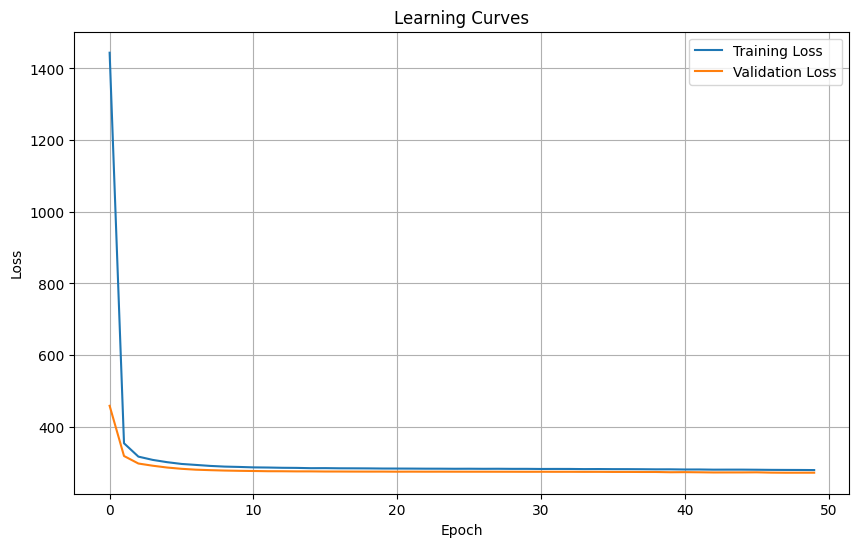

In [86]:
def train_model(model, train_dataset, validation_dataset, epochs=100):
    # Thiết lập early stopping và giảm learning rate
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6
    )
    
    # Huấn luyện mô hình
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr],
    )
    
    # Vẽ đồ thị quá trình huấn luyện
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Learning Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return history

# Huấn luyện mô hình
history = train_model(model, train_dataset, validation_dataset, epochs=50)

**Đánh giá và sử dụng mô hình**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


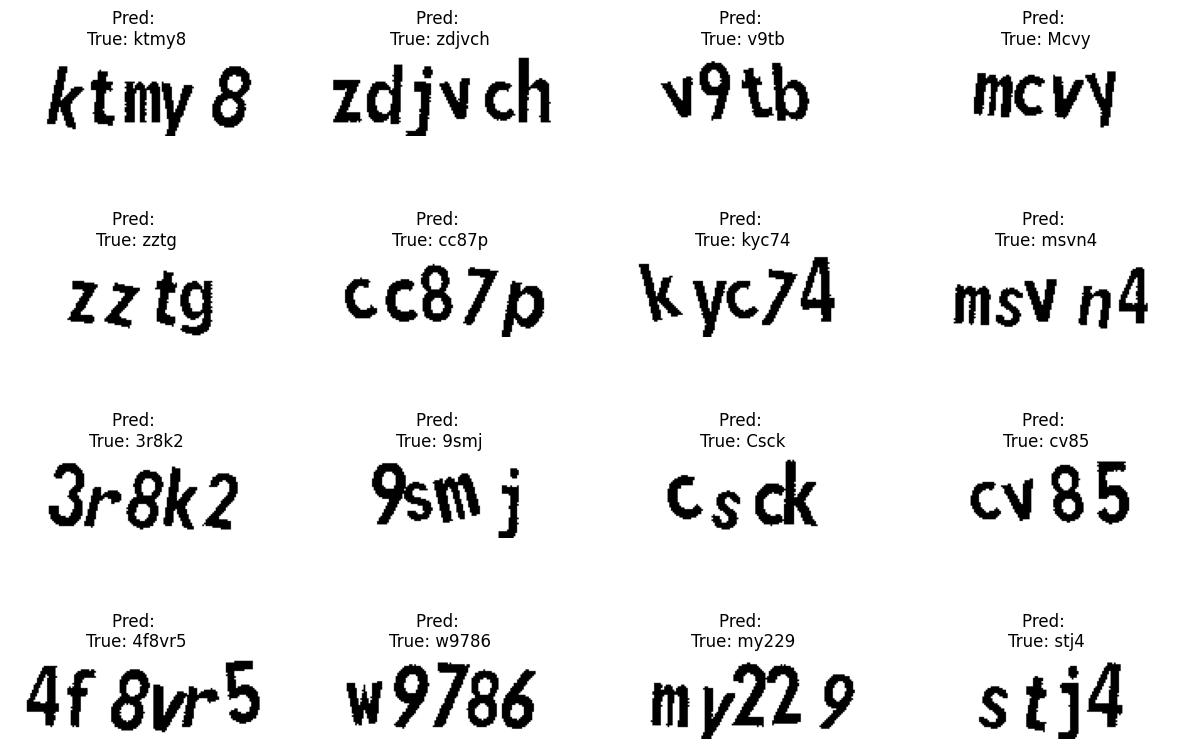

In [87]:
# Tạo một ô code mới sau phần "Huấn luyện mô hình"

# Hàm giải mã dự đoán
def decode_batch_predictions(pred):
    """Giải mã đầu ra của mô hình"""
    # Sử dụng CTC greedy decoder
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    
    # Chuyển đổi thành văn bản
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Hàm dự đoán với mô hình đã được huấn luyện
def predict(model, images):
    """Dự đoán với mô hình đã được huấn luyện"""
    # Chuẩn bị dữ liệu giả để cung cấp cho mô hình
    batch_size = images.shape[0]
    
    # Tạo nhãn giả và độ dài nhãn giả
    dummy_labels = tf.zeros((batch_size, 1), dtype=tf.int64)
    dummy_label_lengths = tf.ones((batch_size,), dtype=tf.int32)
    
    # Dự đoán
    preds = model.predict([images, dummy_labels, dummy_label_lengths], verbose=0)
    
    # Giải mã kết quả
    decoded_texts = decode_batch_predictions(preds)
    
    return decoded_texts

# Thêm vào phần "Đánh giá và dự đoán" sau hàm predict

# Hàm hiển thị kết quả dự đoán
def visualize_predictions(model, dataset):
    """Hiển thị kết quả dự đoán trên một batch"""
    for batch in dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]
        batch_label_lengths = batch["label_length"]
        
        # Dự đoán
        preds = model.predict([batch_images, batch_labels, batch_label_lengths])
        pred_texts = decode_batch_predictions(preds)
        
        # Lấy nhãn gốc
        orig_texts = []
        for i, (label, length) in enumerate(zip(batch_labels.numpy(), batch_label_lengths.numpy())):
            # Chỉ lấy phần thực của nhãn (không lấy padding)
            label_tensor = tf.convert_to_tensor(label[:length])
            orig_text = tf.strings.reduce_join(num_to_char(label_tensor)).numpy().decode('utf-8')
            orig_texts.append(orig_text)
        
        # Hiển thị kết quả
        fig, axs = plt.subplots(4, 4, figsize=(15, 10))
        for i in range(min(16, len(pred_texts))):
            img = batch_images[i, :, :, 0].numpy()
            img = np.transpose(img, (1, 0)) # Chuyển về định dạng đúng để hiển thị
            axs[i // 4, i % 4].imshow(img, cmap="gray")
            title = f"Pred: {pred_texts[i]}"
            if pred_texts[i] != orig_texts[i]:
                title += f"\nTrue: {orig_texts[i]}"
            axs[i // 4, i % 4].set_title(title)
            axs[i // 4, i % 4].axis("off")
        plt.show()

# Đánh giá mô hình trên tập kiểm định
visualize_predictions(model, validation_dataset)

**Đánh giá độ chính xác**

In [88]:
# Đánh giá độ chính xác
# Hàm tính độ chính xác đã được sửa
def calculate_accuracy(model, dataset):
    """Tính toán độ chính xác trên một tập dataset"""
    correct_predictions = 0
    total_samples = 0
    
    for batch in dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]
        batch_label_lengths = batch["label_length"]
        
        # Lấy nhãn gốc
        orig_texts = []
        for i, (label, length) in enumerate(zip(batch_labels.numpy(), batch_label_lengths.numpy())):
            # Chỉ lấy phần thực của nhãn (không lấy padding)
            label_tensor = tf.convert_to_tensor(label[:length])
            orig_text = tf.strings.reduce_join(num_to_char(label_tensor)).numpy().decode('utf-8')
            orig_texts.append(orig_text)
        
        # Dự đoán
        preds = model.predict([batch_images, batch_labels, batch_label_lengths], verbose=0)
        pred_texts = decode_batch_predictions(preds)
        
        # In ra một số ví dụ để debug
        if total_samples == 0:
            print("Một số ví dụ dự đoán:")
            for i in range(min(5, len(pred_texts))):
                print(f"Thực tế: '{orig_texts[i]}', Dự đoán: '{pred_texts[i]}'")
        
        # So sánh dự đoán với nhãn thực tế
        for i in range(len(pred_texts)):
            if pred_texts[i] == orig_texts[i]:
                correct_predictions += 1
            total_samples += 1
            
    return correct_predictions / total_samples

# Tính Character Error Rate (CER)
def calculate_cer(dataset):
    """Tính toán Character Error Rate"""
    total_edit_distance = 0
    total_chars = 0
    
    for batch in dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]
        
        # Lấy nhãn gốc
        orig_texts = []
        for label in batch_labels:
            # Bỏ qua các giá trị padding (-1)
            label = tf.gather(label, tf.where(tf.not_equal(label, -1)))
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)
        
        # Dự đoán
        pred_texts = predict(model, batch_images, batch_labels)
        
        # Tính edit distance
        for i in range(len(pred_texts)):
            # Levenshtein distance tính bằng tf.edit_distance
            pred_sparse = tf.sparse.from_dense([[ord(c) for c in pred_texts[i]]])
            true_sparse = tf.sparse.from_dense([[ord(c) for c in orig_texts[i]]])
            
            distance = tf.edit_distance(pred_sparse, true_sparse, normalize=False)
            total_edit_distance += distance.numpy()[0]
            total_chars += len(orig_texts[i])
            
    return float(total_edit_distance) / float(total_chars)

# cer = calculate_cer(validation_dataset)
validation_accuracy = calculate_accuracy(model, validation_dataset)
print(f"Độ chính xác trên tập kiểm định: {validation_accuracy:.2%}")

Một số ví dụ dự đoán:
Thực tế: 'ktmy8', Dự đoán: ''
Thực tế: 'zdjvch', Dự đoán: ''
Thực tế: 'v9tb', Dự đoán: ''
Thực tế: 'Mcvy', Dự đoán: ''
Thực tế: 'zztg', Dự đoán: ''
Độ chính xác trên tập kiểm định: 0.00%



--- CHI TIẾT DỰ ĐOÁN ---
STT | THỰC TẾ | DỰ ĐOÁN | KẾT QUẢ
--------------------------
 1 | ktmy8    |          | ✗
 2 | zdjvch   |          | ✗
 3 | v9tb     |          | ✗
 4 | Mcvy     |          | ✗
 5 | zztg     |          | ✗
 6 | cc87p    |          | ✗
 7 | kyc74    |          | ✗
 8 | msvn4    |          | ✗
 9 | 3r8k2    |          | ✗
10 | 9smj     |          | ✗
11 | Csck     |          | ✗
12 | cv85     |          | ✗
13 | 4f8vr5   |          | ✗
14 | w9786    |          | ✗
15 | my229    |          | ✗
16 | stj4     |          | ✗
17 | xygw     |          | ✗
18 | wSzp     |          | ✗
19 | 3CVcZh   |          | ✗
20 | kcqc     |          | ✗
--------------------------
Tỷ lệ đúng: 0/20 (0.00%)


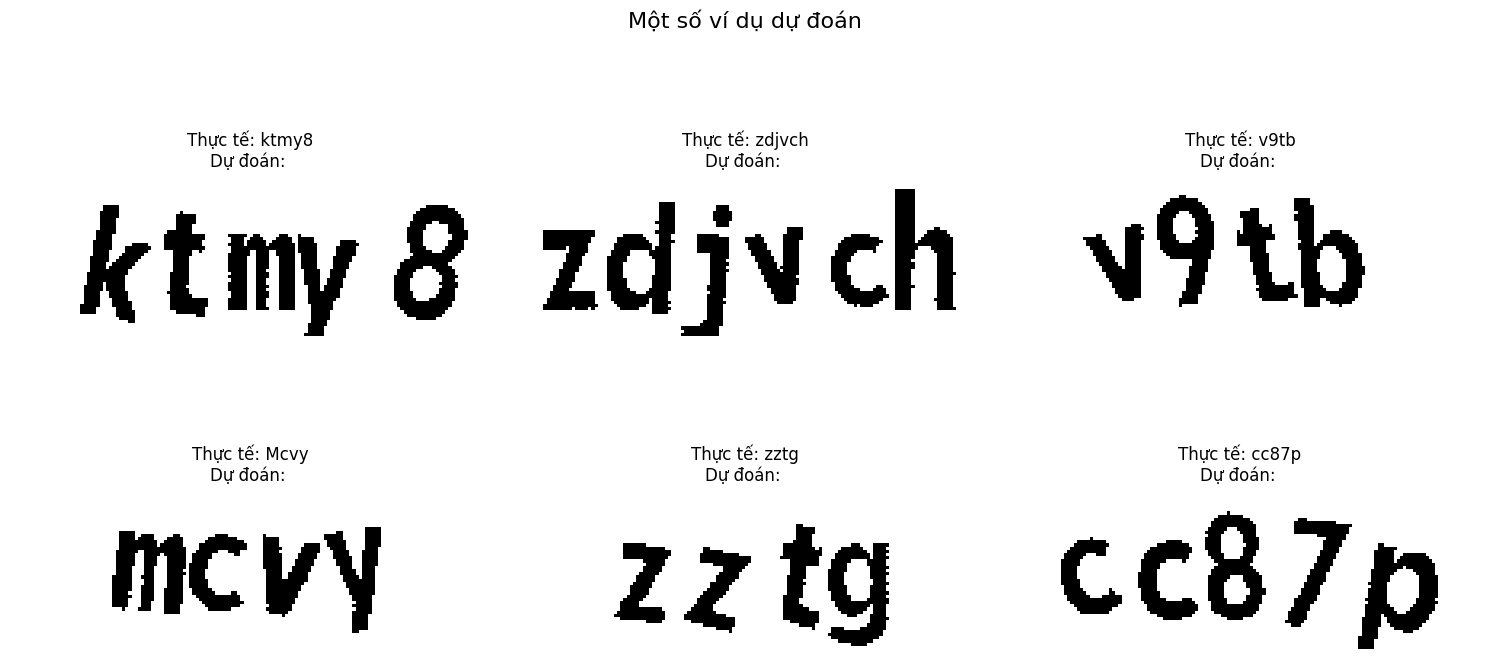

In [89]:
# Kiểm tra chi tiết các lỗi dự đoán
def analyze_predictions(model, dataset, num_examples=10):
    """Phân tích chi tiết các dự đoán đúng và sai"""
    all_predictions = []
    all_originals = []
    all_images = []
    
    for batch in dataset.take(2):  # Chỉ lấy 2 batch để kiểm tra
        batch_images = batch["image"]
        batch_labels = batch["label"]
        batch_label_lengths = batch["label_length"]
        
        # Lấy nhãn gốc
        orig_texts = []
        for i, (label, length) in enumerate(zip(batch_labels.numpy(), batch_label_lengths.numpy())):
            label_tensor = tf.convert_to_tensor(label[:length])
            orig_text = tf.strings.reduce_join(num_to_char(label_tensor)).numpy().decode('utf-8')
            orig_texts.append(orig_text)
        
        # Dự đoán
        preds = model.predict([batch_images, batch_labels, batch_label_lengths], verbose=0)
        pred_texts = decode_batch_predictions(preds)
        
        # Lưu kết quả
        all_predictions.extend(pred_texts)
        all_originals.extend(orig_texts)
        all_images.extend([img.numpy() for img in batch_images])
        
        # Chỉ lấy một số lượng nhất định
        if len(all_predictions) >= num_examples:
            break
    
    # Hiển thị chi tiết
    correct = 0
    print("\n--- CHI TIẾT DỰ ĐOÁN ---")
    print("STT | THỰC TẾ | DỰ ĐOÁN | KẾT QUẢ")
    print("--------------------------")
    
    for i in range(min(num_examples, len(all_predictions))):
        result = "✓" if all_predictions[i] == all_originals[i] else "✗"
        if result == "✓":
            correct += 1
        print(f"{i+1:2d} | {all_originals[i]:8s} | {all_predictions[i]:8s} | {result}")
    
    print("--------------------------")
    print(f"Tỷ lệ đúng: {correct}/{min(num_examples, len(all_predictions))} ({correct/min(num_examples, len(all_predictions)):.2%})")
    
    # Hiển thị một số lỗi dự đoán
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle("Một số ví dụ dự đoán", fontsize=16)
    
    count = 0
    for i in range(min(num_examples, len(all_predictions))):
        if count >= 6:
            break
            
        if all_predictions[i] != all_originals[i] or count < 3:  # Hiển thị cả đúng và sai
            row, col = count // 3, count % 3
            img = all_images[i][:, :, 0]
            img = np.transpose(img, (1, 0))
            axs[row, col].imshow(img, cmap="gray")
            title = f"Thực tế: {all_originals[i]}\nDự đoán: {all_predictions[i]}"
            axs[row, col].set_title(title)
            axs[row, col].axis("off")
            count += 1
    
    plt.tight_layout()
    plt.show()

# Phân tích chi tiết các dự đoán
analyze_predictions(model, validation_dataset, num_examples=20)

**Lưu mô hình**

In [90]:
# Tạo một ô code mới sau phần "Tính độ chính xác"

# Lưu mô hình
model.save_weights('captcha_model.weights.h5')

# Lưu kiến trúc mô hình dưới dạng JSON
json_string = model.to_json()
with open('captcha_model_architecture.json', 'w') as f:
    f.write(json_string)

# Lưu từ điển ký tự
np.save('char_to_num.npy', char_to_num.get_vocabulary())

def load_model_from_files():
    # Tải kiến trúc mô hình
    with open('captcha_model_architecture.json', 'r') as f:
        json_string = f.read()
    loaded_model = keras.models.model_from_json(json_string, custom_objects={"CTCLayer": CTCLayer})
    
    # Tải trọng số - lưu ý tên file đã thay đổi
    loaded_model.load_weights('captcha_model.weights.h5')
    
    # Tải từ điển ký tự
    vocabulary = np.load('char_to_num.npy')
    
    return loaded_model, vocabulary

# Tải mô hình (chỉ để kiểm tra)
loaded_model, vocabulary = load_model_from_files()
print("Mô hình đã được tải thành công!")

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': None, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class '__main__.CTCLayer'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'CTCLayer', 'config': {'name': 'ctc_loss', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'CTCLayer', 'build_config': {'input_shape': [None, None]}, 'name': 'ctc_loss', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, None], 'dtype': 'int64', 'keras_history': ['label', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 37, 45], 'dtype': 'float32', 'keras_history': ['dense2', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None], 'dtype': 'int32', 'keras_history': ['label_length', 0, 0]}}], 'kwargs': {}}]}.

Exception encountered: Error when deserializing class 'CTCLayer' using config={'name': 'ctc_loss', 'trainable': True, 'dtype': 'float32'}.

Exception encountered: CTCLayer.__init__() got an unexpected keyword argument 'trainable'

**Hàm dự đoán cho một ảnh đơn lẻ**

In [ ]:
# Tạo một ô code mới sau phần "Lưu và tải mô hình"

# Hàm dự đoán cho một ảnh CAPTCHA đơn lẻ
def predict_single_image(model, num_to_char, image_path):
    """Dự đoán CAPTCHA từ một file ảnh"""
    # Đọc và tiền xử lý ảnh
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    img = tf.expand_dims(img, axis=0)  # Thêm batch dimension
    
    # Tạo nhãn giả với cùng batch_size
    dummy_labels = tf.zeros((1, 1), dtype=tf.int64)
    dummy_label_lengths = tf.ones((1,), dtype=tf.int32)
    
    # Dự đoán
    preds = model.predict([img, dummy_labels, dummy_label_lengths], verbose=0)
    
    # Giải mã kết quả
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    results = keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0]
    result = tf.gather(results[0], tf.where(tf.not_equal(results[0], -1)))
    result_str = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
    
    return result_str

# Kiểm tra với một ảnh cụ thể từ tập dữ liệu
# test_image_path = x_valid[0]
# prediction = predict_single_image(model, num_to_char, test_image_path)
# print(f"CAPTCHA dự đoán: {prediction}")
# print(f"CAPTCHA thật: {y_valid[0]}")

# Hiển thị ảnh kiểm tra
# img = Image.open(test_image_path)
# plt.imshow(img)
# plt.title(f"Dự đoán: {prediction}, Thật: {y_valid[0]}")
# plt.axis("off")
# plt.show()